# Colon Cancer Segmentation - Training the Model

## Environment Setup

### Requirements

In [1]:
INSTALL_REQ = False

if INSTALL_REQ:
    %pip install torch
    %pip installtorchvision 
    %pip install torchvision monai nibabel matplotlib tqdm pyyaml scikit-image tensorboard

In [ ]:
%pip install --upgrade jupyter ipywidgets

### Imports

In [1]:
import os
import yaml
import json
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import sys
#sys.path.append(os.path.abspath('../'))

# Import project-specific modules
from src.utils.data_utils import set_random_seed, create_data_loaders
from src.utils.model_utils import (
    create_loss_function, 
    create_optimizer, 
    create_scheduler,
    save_model,
    predict_with_sliding_window, 
    create_evaluation_metric
)
from src.utils.visualization import (
    visualize_slice,
    plot_training_curves,
    save_visualization
)
from src.models.network import initialize_model

(self, spatial_dims: int, in_channels: int, out_channels: int, kernel_size: Sequence[Union[Sequence[int], int]], strides: Sequence[Union[Sequence[int], int]], upsample_kernel_size: Sequence[Union[Sequence[int], int]], filters: Optional[Sequence[int]] = None, dropout: Union[Tuple, str, float, NoneType] = None, norm_name: Union[Tuple, str] = ('INSTANCE', {'affine': True}), act_name: Union[Tuple, str] = ('leakyrelu', {'inplace': True, 'negative_slope': 0.01}), deep_supervision: bool = False, deep_supr_num: int = 1, res_block: bool = False, trans_bias: bool = False)


## Configuration

In [2]:
# Load config from file
def load_config(config_path=os.path.join("configs", "train_config.yaml")):
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config

config = load_config()
print("Loaded configuration:")
print(json.dumps(config, indent=2))

# For example, reduce the number of epochs for a test run
config["max_epochs"] = 50  # Reduced from 1000 for demonstration
config["val_interval"] = 5  # Validate every 5 epochs
config["device"] = "cuda" if torch.cuda.is_available() else "cpu"
config["batch_size"] = 2  # Adjust based on your GPU memory
config["model_type"] = "unet"  # Choose from: unet, basicunet, dynunet

# Define output directory
experiment_name = f"{config['model_type']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
output_dir = os.path.join("outputs", experiment_name)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "visualizations"), exist_ok=True)

# Save updated config
with open(os.path.join(output_dir, "config.yaml"), "w") as f:
    yaml.dump(config, f, default_flow_style=False)

Loaded configuration:
{
  "model_type": "dynunet",
  "in_channels": 1,
  "out_channels": 2,
  "dimensions": 3,
  "data_dir": "./data/Task10_Colon",
  "validation_split": 0.2,
  "intensity_bounds": [
    -175,
    250
  ],
  "patch_size": [
    96,
    96,
    96
  ],
  "pos_sample_ratio": 0.7,
  "batch_size": 2,
  "val_batch_size": 1,
  "max_epochs": 1000,
  "early_stopping_patience": 50,
  "num_workers": 4,
  "optimizer": {
    "type": "adamw",
    "lr": 0.0003,
    "weight_decay": 1e-05
  },
  "scheduler": {
    "mode": "min",
    "factor": 0.5,
    "patience": 20,
    "verbose": true
  },
  "loss": {
    "include_background": false,
    "to_onehot_y": true,
    "softmax": true,
    "sigmoid": false,
    "use_ce": true
  },
  "metric": {
    "include_background": false,
    "reduction": "mean"
  },
  "sw_batch_size": 4,
  "overlap": 0.5,
  "checkpoint_interval": 50,
  "val_interval": 10,
  "vis_interval": 10,
  "plot_interval": 10,
  "output_dir": "./outputs",
  "device": "cuda",
  "

## Data Preparation

c:\Users\cmore\anaconda3\envs\colon_seg\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Using conservative patch size: [96, 96, 80]
Training samples: 101, Validation samples: 25


Loading dataset: 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


Using a pos_sample_ratio: 0.7
Training samples: 101
Validation samples: 25


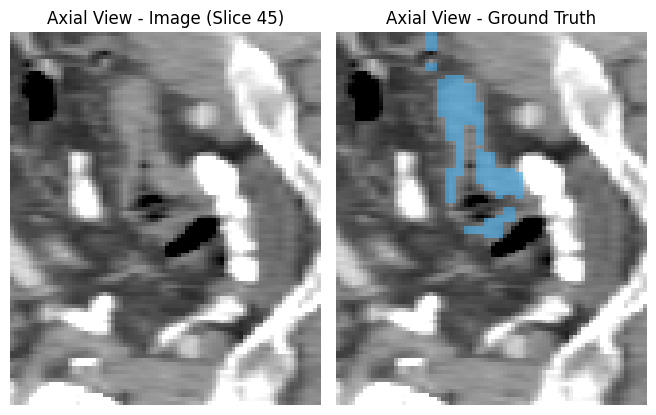

In [20]:
# Set random seed for reproducibility
set_random_seed(config["seed"])

print(f"Using conservative patch size: {config['patch_size']}")

# Re-create data loaders with the smaller patch size
train_loader, val_loader = create_data_loaders(
    data_dir=config["data_dir"],
    batch_size=config["batch_size"],
    val_batch_size=config["val_batch_size"],
    num_workers=config["num_workers"],
    validation_split=config["validation_split"],
    pin_memory=True,
    spatial_size=config["patch_size"],
    pos_sample_ratio=config["pos_sample_ratio"],
    intensity_bounds=config["intensity_bounds"]
)

print(f"Using a pos_sample_ratio: {config['pos_sample_ratio']}")


print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")

train_sample = next(iter(train_loader))
image = train_sample["image"][0].numpy()
label = train_sample["label"][0].numpy()

fig = visualize_slice(
    image=image,
    ground_truth=label,
    slice_idx=None,         # Automatically find a slice with segmentation
    axis=0,                 # Axial view
    figsize=(10, 5)
)
plt.show()

## Model Initialization

In [21]:
# Create model
device = torch.device(config["device"])
print(f"Using device: {device}")

model = initialize_model(
    model_type=config["model_type"],
    in_channels=config["in_channels"],
    out_channels=config["out_channels"],
    dimensions=config["dimensions"],
    device=device
)

# Print model summary
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Created {config['model_type']} model with {num_params:,} trainable parameters")

Using device: cuda
Created unet model with 4,808,917 trainable parameters


## Loss Function, Optimizer and Scheduler

In [22]:
# Create loss function
loss_fn = create_loss_function(
    include_background=config["loss"]["include_background"],
    to_onehot_y=config["loss"]["to_onehot_y"],
    softmax=config["loss"]["softmax"],
    sigmoid=config["loss"]["sigmoid"],
    use_ce=config["loss"]["use_ce"]
)

# Create optimizer
optimizer = create_optimizer(
    model=model,
    learning_rate=config["optimizer"]["lr"],
    weight_decay=config["optimizer"]["weight_decay"],
    optimizer_type=config["optimizer"]["type"]
)

# Create scheduler
scheduler = create_scheduler(
    optimizer=optimizer,
    mode=config["scheduler"]["mode"],
    factor=config["scheduler"]["factor"],
    patience=config["scheduler"]["patience"],
    verbose=config["scheduler"]["verbose"]
)

# Create metric for validation
metric_fn = create_evaluation_metric(
    include_background=config["metric"]["include_background"],
    reduction=config["metric"]["reduction"]
)

c:\Users\cmore\anaconda3\envs\colon_seg\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training Loop

In [23]:
def train_epoch(model, train_loader, optimizer, loss_fn, device, epoch, max_epochs):
    """Train model for one epoch."""
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}")
    
    for batch_idx, batch_data in enumerate(progress_bar):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        if config['model_type'] == 'dynunet' and hasattr(model, 'net') and hasattr(model.net, 'do_ds') and model.net.do_ds:
            # Handle deep supervision outputs
            outputs = model(inputs)
            
            # Use all deep supervision outputs with different weights
            if isinstance(outputs, list):
                # Apply loss to each output with descending weights
                ds_weights = [0.5 ** i for i in range(len(outputs))]
                ds_weights = [w / sum(ds_weights) for w in ds_weights]  # Normalize weights
                
                # Calculate weighted loss for each deep supervision output
                losses = [loss_fn(out, labels) * weight for out, weight in zip(outputs, ds_weights)]
                loss = sum(losses)
            else:
                # Fallback if output is not a list
                loss = loss_fn(outputs, labels)
        else:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    return epoch_loss / len(train_loader)



def validate(model, val_loader, loss_fn, metric_fn, device, config):
    """Validate the model."""
    model.eval()
    val_loss = 0
    metric_fn.reset()
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(val_loader):
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            
            # Sliding window inference for validation
            outputs = predict_with_sliding_window(
                model, inputs, 
                roi_size=config['patch_size'], 
                sw_batch_size=config['sw_batch_size'],
                overlap=config['overlap']
            )
            
            # Calculate validation loss
            val_loss_batch = loss_fn(outputs, labels)
            val_loss += val_loss_batch.item()
            
            # Compute metric
            if config['model_type'] == 'dynunet' and isinstance(outputs, list):
                outputs = outputs[0]
            
            metric_fn(y_pred=outputs, y=labels)
    
    # Aggregate metrics
    metric = metric_fn.aggregate().item()
    metric_fn.reset()
    
    return val_loss / len(val_loader), metric



def visualize_validation_sample(model, val_loader, device, output_dir, epoch, config):
    """Visualize a validation sample with model prediction."""
    model.eval()
    
    # Get a validation sample
    val_data = next(iter(val_loader))
    image = val_data["image"].to(device)
    label = val_data["label"].to(device)
    
    with torch.no_grad():
        # Sliding window inference
        prediction = predict_with_sliding_window(
            model, image, 
            roi_size=config['patch_size'], 
            sw_batch_size=config['sw_batch_size'],
            overlap=config['overlap']
        )
        
        # Apply softmax and get binary prediction
        if config['model_type'] == 'dynunet' and isinstance(prediction, list):
            prediction = prediction[0]  # Take final output
        
        prediction_softmax = torch.softmax(prediction, dim=1)
        prediction_binary = torch.argmax(prediction_softmax, dim=1, keepdim=True)
    
    # Visualize prediction
    fig = visualize_slice(
        image=image[0].cpu().numpy(),
        prediction=prediction_binary[0].cpu().numpy(),
        ground_truth=label[0].cpu().numpy(),
        slice_idx=None,
        axis=0,
        figsize=(15, 5),
        alpha=0.5
    )
    
    # Save visualization
    vis_path = os.path.join(output_dir, "visualizations", f"val_pred_epoch_{epoch}.png")
    plt.savefig(vis_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    
    # Display in notebook
    return fig






In [19]:


# Initialize training variables
start_epoch = 0
best_metric = -1
best_metric_epoch = -1
best_model_path = os.path.join(output_dir, "checkpoints", f"best_model_{config['model_type']}.pth")
patience_counter = 0
train_losses = []
val_losses = []
val_metrics = []

# Training loop
start_time = time.time()

for epoch in range(start_epoch, config["max_epochs"]):
    # Train one epoch
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device, epoch + 1, config["max_epochs"])
    train_losses.append(train_loss)
    
    print(f"Epoch {epoch + 1}/{config['max_epochs']}, Average Loss: {train_loss:.4f}")
    
    # Validate model
    if (epoch + 1) % config["val_interval"] == 0:
        val_loss, metric = validate(model, val_loader, loss_fn, metric_fn, device, config)
        val_losses.append(val_loss)
        val_metrics.append(metric)
        
        scheduler.step(val_loss)
        
        print(f"Validation Loss: {val_loss:.4f}, Metric: {metric:.4f}")
        
        # Save visualization of a validation sample
        if (epoch + 1) % config["vis_interval"] == 0:
            fig = visualize_validation_sample(model, val_loader, device, output_dir, epoch + 1, config)
            plt.figure(figsize=(15, 5))
            plt.imshow(plt.imread(os.path.join(output_dir, "visualizations", f"val_pred_epoch_{epoch + 1}.png")))
            plt.axis('off')
            plt.show()
        
        # Save best model
        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            
            save_model(
                model=model,
                path=best_model_path,
                epoch=epoch,
                optimizer=optimizer,
                scheduler=scheduler,
                best_metric=best_metric
            )
            
            print(f"New best model saved with metric: {best_metric:.4f} at epoch {best_metric_epoch}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Save checkpoint
        if (epoch + 1) % config["checkpoint_interval"] == 0:
            checkpoint_path = os.path.join(output_dir, "checkpoints", f"checkpoint_epoch_{epoch + 1}.pth")
            save_model(
                model=model,
                path=checkpoint_path,
                epoch=epoch,
                optimizer=optimizer,
                scheduler=scheduler,
                best_metric=best_metric
            )
        
        # Early stopping
        if patience_counter >= config["early_stopping_patience"]:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
        
        # Plot and save training curves
        if val_losses and (epoch + 1) % config["plot_interval"] == 0:
            fig = plot_training_curves(
                metrics_dict={
                    "Training Loss": train_losses,
                    "Validation Loss": val_losses,
                    "Validation Metric (Dice)": val_metrics
                }
            )
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "training_curves.png"), dpi=150, bbox_inches='tight')
            plt.show()

# Training finished
total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f}min)")
print(f"Best metric: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch 1/50:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1/50, Average Loss: 1.7916


Epoch 2/50:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2/50, Average Loss: 1.5563


Epoch 3/50:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3/50, Average Loss: 1.3928


Epoch 4/50:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4/50, Average Loss: 1.2766


Epoch 5/50:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5/50, Average Loss: 1.1936
Validation Loss: 1.2016, Metric: 0.0013
New best model saved with metric: 0.0013 at epoch 5


Epoch 6/50:   0%|          | 0/51 [00:00<?, ?it/s]

## Evaluate Best Model

In [ ]:
# Load the best model
def load_model(path, model, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

best_model = initialize_model(
    model_type=config["model_type"],
    in_channels=config["in_channels"],
    out_channels=config["out_channels"],
    dimensions=config["dimensions"],
    device=device
)

best_model = load_model(best_model_path, best_model, device)
print(f"Loaded best model from epoch {best_metric_epoch}")

# Evaluate the best model on validation set
val_loss, val_metric = validate(best_model, val_loader, loss_fn, metric_fn, device, config)
print(f"Best model evaluation - Validation Loss: {val_loss:.4f}, Dice: {val_metric:.4f}")

## Visualize Results

In [ ]:
# Create a function to visualize multiple samples
def visualize_multiple_predictions(model, data_loader, device, config, num_samples=5):
    """Visualize predictions for multiple samples."""
    model.eval()
    
    # Get samples
    samples = [next(iter(data_loader)) for _ in range(num_samples)]
    
    for i, sample in enumerate(samples):
        image = sample["image"].to(device)
        label = sample["label"].to(device)
        
        with torch.no_grad():
            # Sliding window inference
            prediction = predict_with_sliding_window(
                model, image, 
                roi_size=config['patch_size'], 
                sw_batch_size=config['sw_batch_size'],
                overlap=config['overlap']
            )
            
            # Apply softmax and get binary prediction
            if config['model_type'] == 'dynunet' and isinstance(prediction, list):
                prediction = prediction[0]  # Take final output
            
            prediction_softmax = torch.softmax(prediction, dim=1)
            prediction_binary = torch.argmax(prediction_softmax, dim=1, keepdim=True)
        
        # Visualize prediction
        fig = visualize_slice(
            image=image[0].cpu().numpy(),
            prediction=prediction_binary[0].cpu().numpy(),
            ground_truth=label[0].cpu().numpy(),
            slice_idx=None,
            axis=0,
            figsize=(15, 5),
            alpha=0.5
        )
        
        plt.figure(figsize=(15, 5))
        plt.imshow(plt.imread(os.path.join(output_dir, "visualizations", f"sample_{i+1}.png")))
        plt.axis('off')
        plt.title(f"Sample {i+1}")
        plt.show()
        
        # Save visualization
        save_visualization(
            fig=fig,
            save_path=os.path.join(output_dir, "visualizations", f"sample_{i+1}.png"),
            dpi=150
        )


# Visualize predictions on validation samples
visualize_multiple_predictions(best_model, val_loader, device, config, num_samples=3)

## Save Final Results

In [ ]:
# Plot final training curves
fig = plot_training_curves(
    metrics_dict={
        "Training Loss": train_losses,
        "Validation Loss": val_losses,
        "Validation Metric (Dice)": val_metrics
    }
)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "training_curves_final.png"), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Save training history
history = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_metric": val_metrics,
    "best_metric": float(best_metric),
    "best_metric_epoch": int(best_metric_epoch),
    "total_time": float(total_time)
}

with open(os.path.join(output_dir, "training_history.json"), "w") as f:
    json.dump(history, f)

print(f"Training history saved to {os.path.join(output_dir, 'training_history.json')}")

In [ ]:
# Create a training summary
summary = f"""
# Training Summary

## Model Information
- Model type: {config['model_type']}
- Input channels: {config['in_channels']}
- Output channels: {config['out_channels']}
- Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}

## Training Configuration
- Batch size: {config['batch_size']}
- Learning rate: {config['optimizer']['lr']}
- Optimizer: {config['optimizer']['type']}
- Loss function: {'Dice + Cross-Entropy' if config['loss']['use_ce'] else 'Dice'}
- Patch size: {config['patch_size']}

## Results
- Best Dice score: {best_metric:.4f} (epoch {best_metric_epoch})
- Final Dice score: {val_metric:.4f}
- Training time: {total_time/60:.2f} minutes
- Early stopping: {'Yes' if patience_counter >= config['early_stopping_patience'] else 'No'}
"""

with open(os.path.join(output_dir, "training_summary.md"), "w") as f:
    f.write(summary)

print(summary)